In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.inspection import permutation_importance


In [2]:
csv_path = '/Users/vibeke/Desktop/forest/stor data/all_songsstor.csv'
df = pd.read_csv(csv_path)
df = df[df["track_genre"] != "other"]

Preparing Data

In [ ]:

df = df[df["track_genre"] != "other"]


X = df[[
    "popularity", "duration_ms", "explicit", "danceability", "energy",
    "key", "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "time_signature"
]]


Y = df["track_genre"]


In [22]:
Y.value_counts()

track_genre
rock          23000
electronic    18000
pop           12000
jazz_soul      9000
roots          5000
hiphop         3000
Name: count, dtype: int64

Splitting training and test data 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

First there is run a RandomSearch once

In [44]:
forest = RandomForestClassifier(random_state=1, n_jobs=-1)

parameters = {
    'n_estimators': [10, 50, 100, 300, 500, 600, 900],
    'max_depth': [10, 30, 50, 70, 90],
    'max_features': [1, 2, 3, 4, 5, 7, 10],  
    'min_samples_leaf': [1, 2, 4, 5, 10],
    'min_samples_split': [2, 3, 5, 10]}


gridrandom1 = RandomizedSearchCV(
    forest,
    parameters,
    n_iter=15,
    random_state=1,
    n_jobs=-1,
    scoring="accuracy",
    return_train_score=False)

gridrandom1.fit(X_train, y_train)

results1 = pd.DataFrame(gridrandom1.cv_results_)

bestParams1 = results1[[
    "param_n_estimators",
    "param_max_depth",
    "param_max_features",
    "param_min_samples_leaf",
    "param_min_samples_split",
    "mean_test_score"
]].sort_values("mean_test_score", ascending=False)

print(bestParams1.head(10))

    param_n_estimators  param_max_depth  param_max_features  \
14                 900               70                   5   
6                  500               90                   3   
3                  600               50                   7   
4                  500               50                  10   
8                  500               70                   4   
9                  600               30                   2   
7                  500               50                   7   
12                 300               50                   4   
1                  500               90                   1   
10                  50               90                   4   

    param_min_samples_leaf  param_min_samples_split  mean_test_score  
14                       4                        2         0.674514  
6                        1                       10         0.672495  
3                        5                        5         0.672286  
4                     

Then again but with a smaller selection of parameters and fewer iterations 

In [45]:
forest2 = RandomForestClassifier(random_state=1, n_jobs=-1)

parameters2 = {
    'n_estimators': [ 500, 600],
    'max_depth':  [50, 70],
    'max_features':  [4, 7],  
    'min_samples_leaf': [4, 5, 10],
    'min_samples_split': [2, 5, 10]}


gridrandom2 = RandomizedSearchCV(
    forest2,
    parameters2,
    n_iter=5,
    random_state=1,
    n_jobs=-1,
    scoring="accuracy",
    return_train_score=False,
    cv=3)

gridrandom2.fit(X_train, y_train)

results2 = pd.DataFrame(gridrandom1.cv_results_)

bestParams2 = results1[[
    "param_n_estimators",
    "param_max_depth",
    "param_max_features",
    "param_min_samples_leaf",
    "param_min_samples_split",
    "mean_test_score"
]].sort_values("mean_test_score", ascending=False)

print(bestParams2.head(5))

    param_n_estimators  param_max_depth  param_max_features  \
14                 900               70                   5   
6                  500               90                   3   
3                  600               50                   7   
4                  500               50                  10   
8                  500               70                   4   

    param_min_samples_leaf  param_min_samples_split  mean_test_score  
14                       4                        2         0.674514  
6                        1                       10         0.672495  
3                        5                        5         0.672286  
4                        5                        3         0.671295  
8                        5                        5         0.669352  


Then there is a grid search run to get more exact parameters 

In [ ]:
parametersgrid = {
    'n_estimators': [ 500, 600],
    'max_depth':  [50, 70],
    'max_features':  [4, 5, 7],  
    'min_samples_leaf': [4, 5],
    'min_samples_split': [3, 5]}


base = RandomForestClassifier(
    random_state=1,
    n_jobs=-1
)

grid = GridSearchCV(
    estimator=base,
    param_grid=parametersgrid,
    scoring="accuracy",
    n_jobs=-1,
    cv=3
)

grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_)
best_model = grid.best_estimator_
print(best_model)

{'max_depth': 50, 'max_features': 7, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 600}
0.6669714285714287
RandomForestClassifier(max_depth=50, max_features=7, min_samples_leaf=4,
                       min_samples_split=3, n_estimators=600, n_jobs=-1,
                       random_state=1)


Then I make a confusion matrix and classification report:

In [47]:
forestfinal=RandomForestClassifier(
    n_estimators=600,       
    max_depth=50,           
    min_samples_split=3,
    min_samples_leaf=4,    
    max_features=7,
    n_jobs=-1,
    random_state=1)

forestfinal.fit(X_train, y_train)

y_pred_test=forestfinal.predict(X_test)

print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

  electronic       0.77      0.79      0.78      4500
      hiphop       0.50      0.09      0.15       750
   jazz_soul       0.66      0.55      0.60      2250
         pop       0.59      0.57      0.58      3000
        rock       0.68      0.84      0.75      5750
       roots       0.60      0.44      0.51      1250

    accuracy                           0.68     17500
   macro avg       0.63      0.55      0.56     17500
weighted avg       0.67      0.68      0.67     17500



Total size of test=14000

<Figure size 700x600 with 0 Axes>

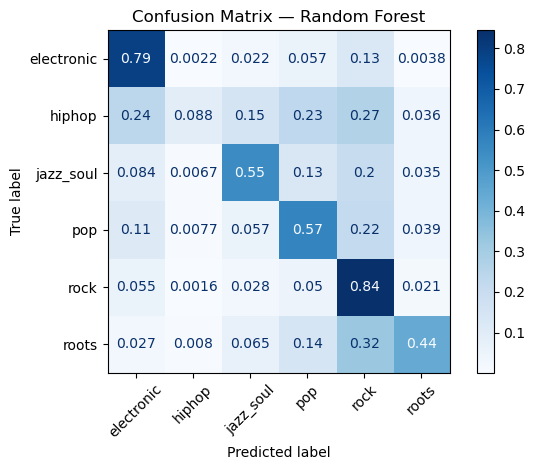

In [ ]:
# Random Forest (samme som du bruger)
forestfinal = RandomForestClassifier(
    n_estimators=600,
    max_depth=50,
    min_samples_split=3,
    min_samples_leaf=4,
    max_features=7,
    n_jobs=-1,
    random_state=1
)

forestfinal.fit(X_train, y_train)
y_pred_test = forestfinal.predict(X_test)

# Confusion matrix i samme stil som SVM-plot
plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    display_labels=sorted(y_test.unique()),   # eller le.classes_ hvis du har den
    xticks_rotation=45,
    normalize="true",
    cmap="Blues"
)

plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()



Feature permutation impoortance 

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=600,
    max_depth=50,
    min_samples_split=3,
    min_samples_leaf=4,
    max_features=7,
    random_state=1,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

perm_rf = permutation_importance(
    rf_model,
    X_test, y_test,
    n_repeats=10,
    random_state=1,
    n_jobs=-1,
    scoring="accuracy"
)

perm_rf_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm_rf.importances_mean,
    "importance_std": perm_rf.importances_std
}).sort_values("importance_mean", ascending=False)

perm_rf_df



,feature,importance_mean,importance_std
0,danceability,0.157931,0.002278
2,popularity,0.116217,0.001877
1,acousticness,0.105314,0.001026
3,valence,0.069463,0.001788
6,instrumentalness,0.066914,0.002191
5,duration_ms,0.039331,0.001169
8,speechiness,0.032269,0.000976
4,energy,0.029223,0.000903
7,tempo,0.026063,0.001420
9,loudness,0.012914,0.000583


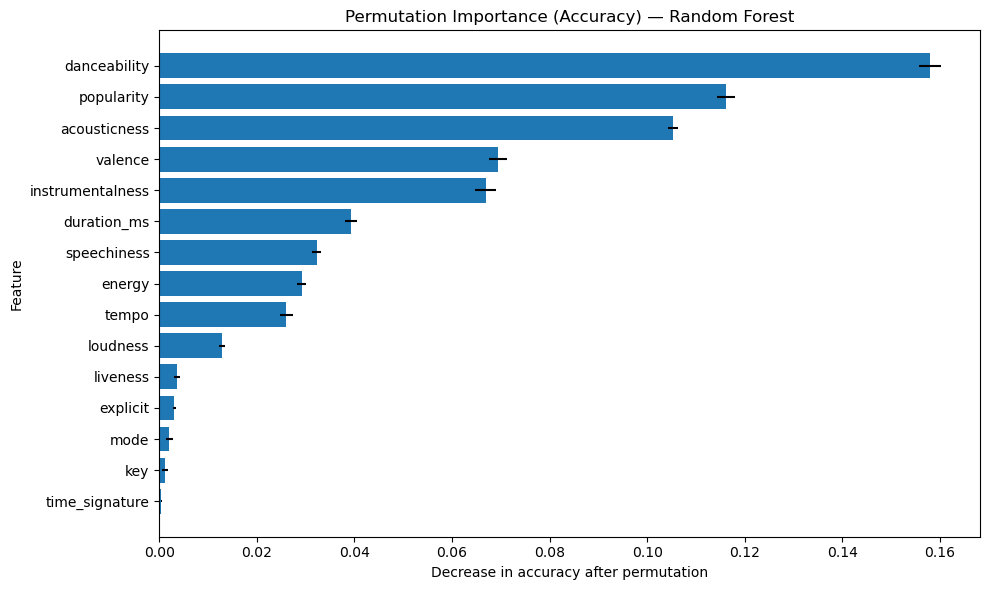

In [59]:
perm_rf_plot = perm_rf_df.sort_values("importance_mean", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    perm_rf_plot["feature"],
    perm_rf_plot["importance_mean"],
    xerr=perm_rf_plot["importance_std"]
)

plt.xlabel("Decrease in accuracy after permutation")
plt.ylabel("Feature")
plt.title("Permutation Importance (Accuracy) — Random Forest")

plt.tight_layout()
plt.show()

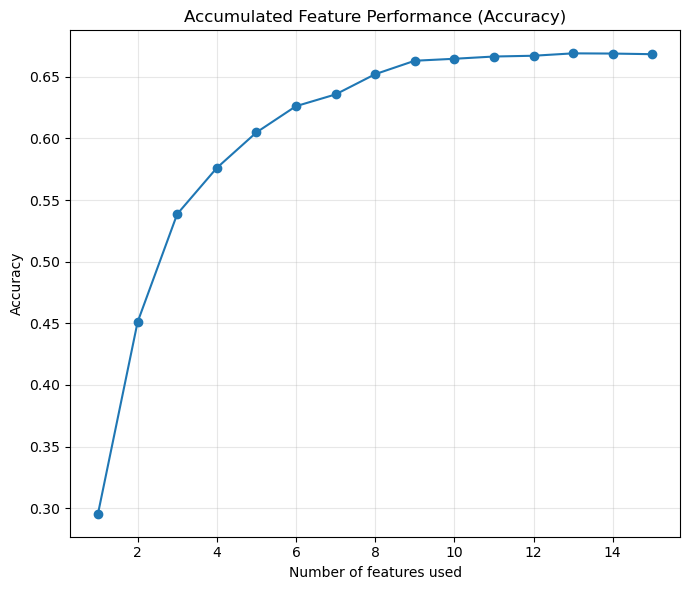

In [62]:
plt.figure(figsize=(7, 6))

plt.plot(
    n_features_used,
    accuracy_scores,
    marker="o"
)

plt.xlabel("Number of features used")
plt.ylabel("Accuracy")
plt.title("Accumulated Feature Performance (Accuracy)")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


OVERSAMPLING

In [64]:
from imblearn.over_sampling import SMOTE
#laver den nye træningsdata vha. på SMOTE

smote = SMOTE(random_state=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#laver random forest

forestsmote = RandomForestClassifier(
    n_estimators=600,
    max_depth=50,
    min_samples_split=3,
    min_samples_leaf=4,
    max_features=7,
    random_state=1,
    n_jobs=-1
)
#træner på dataeen 
forestsmote.fit(X_train_res, y_train_res)

#tester på den samme testdata
y_pred_testsmote = forestsmote.predict(X_test)
accuracy_score(y_test, y_pred_testsmote)

print(classification_report(y_test, y_pred_testsmote))


              precision    recall  f1-score   support

  electronic       0.80      0.73      0.77      4500
      hiphop       0.25      0.35      0.29       750
   jazz_soul       0.60      0.55      0.57      2250
         pop       0.55      0.54      0.54      3000
        rock       0.76      0.70      0.73      5750
       roots       0.41      0.66      0.51      1250

    accuracy                           0.64     17500
   macro avg       0.56      0.59      0.57     17500
weighted avg       0.67      0.64      0.65     17500

